### Load Data

In [96]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
# — adjust this path —
data_path = '/home/maltsevav/Documents/CELLS_TO_ANALYZE/Cell1_12.5pA.tif'

# Extract filename and remove -cut suffix if present
filename = data_path.split('/')[-1].replace('-cut.tif', '.tif')

# Set VAR based on filename
if filename == 'Cell2_25pA.tif':
    VAR = 8
elif filename == 'Cell1_12.5pA.tif':
    VAR = 4
elif filename == 'Cell3_50pA.tif':
    VAR = 16
elif filename == 'Cell3_62.5pA.tif':
    VAR = 16
elif filename == 'Cell4_50pA.tif':
    VAR = 4
else:
    VAR = 1

# ▶︎ Load the TIFF stack (T × H × W)
stack = tifffile.imread(data_path)
T_full, H, W = stack.shape

# ▶︎ Convert to 8-bit if it’s not already
if stack.dtype != np.uint8:
    # scale full range of the data to [0,255]
    stack = stack.astype(np.float32)
    stack -= stack.min()
    stack /= stack.max()
    stack = (stack * 255).astype(np.uint8)

# ▶︎ (Optional) TEST flag to only keep first 400 frames
TEST_MODE = False
MAX_FRAMES = 1000

if TEST_MODE:
    T = min(T_full, MAX_FRAMES)
    stack = stack[:T]
else:
    T = T_full

# ▶︎ Global min–max normalize to [0,1] for display
vmin, vmax = stack.min(), stack.max()
stack_norm = (stack.astype(np.float32) - vmin) / (vmax - vmin)

# ▶︎ Set VAR: show every VAR-th frame
frame_indices = range(0, T, VAR)

# ▶︎ Compute figure size to preserve aspect ratio (width = 6″)
fig_w = 10.0
fig_h = fig_w * (H / W)

# ▶︎ Create figure & axes filling entire canvas
fig = plt.figure(figsize=(fig_w, fig_h))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

# ▶︎ Initialize the image
im = ax.imshow(
    stack_norm[0],
    cmap='gray',
    vmin=0, vmax=1,
    interpolation='nearest',
    animated=True
)

# ▶︎ Update function: receives the actual frame index
def update(frame):
    im.set_array(stack_norm[frame])
    return (im,)

# ▶︎ Build & display the animation, using only every VAR frames
anim = FuncAnimation(
    fig, update,
    frames=frame_indices,
    interval=100,
    blit=True
)
plt.close(fig)
HTML(anim.to_jshtml())

In [131]:
# install ffmpeg
# conda install -c conda-forge ffmpeg

In [132]:
# ----------------------------------------------------------------------------
# 7) Save the animation with autogenerated name based on input file
# ----------------------------------------------------------------------------

import os

# Extract the base filename without path and extension
base_name = os.path.splitext(os.path.basename(data_path))[0]

# Create output filename with LCR tracking suffix
output_filename = f"{base_name}_RAW.mp4"

anim.save(output_filename, 
          writer='ffmpeg', 
          fps=5,  # 5 frames per second for slower playback
          bitrate=1800,  # quality setting
          dpi=100)  # resolution

print(f"Animation saved as '{output_filename}'")

Animation saved as 'Cell1_003_12.5pA_dormant-801-1200_RAW.mp4'


### Multithreaded LCR Filtering

In [133]:
import numpy as np
import scipy.ndimage as ndimage
from scipy.signal    import convolve2d, medfilt2d
from scipy.ndimage   import label, binary_opening, binary_closing, binary_fill_holes
from joblib          import Parallel, delayed

In [134]:
# ▶︎ Flags
use_mean_filter   = False
use_median_filter = False

# ▶︎ Data + params
# ─ Use the original full stack and then slice off only the skipped frames ─
# `stack` was loaded above (shape = (T_full, H, W))
stack_raw_full = stack.astype(np.float32)             # raw intensities as float
stack_raw      = stack_raw_full[frame_indices]        # now shape = (T, H, W)
T, H, W        = stack_raw.shape

cell_sensitivity   = 1.0
r                  = 5       
sd_rise, sd_term   = 0.5, 1
min_pts = 5


# ——— Prep steps (not frame‐parallel) ———
# Get the maximum intensity projection across frames
raw_max = stack_raw.max(axis=0)

# Create cell mask based on intensity threshold
threshold = raw_max.mean() * cell_sensitivity  # Keep original threshold method
cell_mask = raw_max > threshold

# Find the largest connected component size across ALL frames
max_cell_size = 0

# Check each frame to find the largest cell
for t in range(T):
    # Apply the mask to each frame
    frame_mask = stack_raw[t] > threshold
    
    # Find connected components in this frame
    labeled_frame, num_features = ndimage.label(frame_mask)
    
    if num_features > 0:
        # Get sizes of all components in this frame
        component_sizes = ndimage.sum(frame_mask, labeled_frame, range(1, num_features + 1))
        frame_max_size = component_sizes.max()
        
        # Update global maximum if this frame has a larger component
        if frame_max_size > max_cell_size:
            max_cell_size = frame_max_size

print(f"Maximum cell size found: {max_cell_size}")

# Debug info
print(f"Number of pixels in cell_mask: {cell_mask.sum()}")
print(f"Threshold used: {threshold}")


vmin, vmax = stack_raw.min(), stack_raw.max()
norm       = (stack_raw - vmin) / (vmax - vmin)

frame_mean = norm[:, cell_mask].mean(axis=1)
decay      = norm - frame_mean[:, None, None]
decay[decay < 0] = 0

# ▶︎ Build box‐kernel
kernel = np.ones((2*r+1, 2*r+1), float)
ksize  = 2*r + 1

# ——— 1) Smoothed frames ———
def make_smoothed(t):
    f = decay[t]
    if use_mean_filter:
        f = convolve2d(f, kernel, mode='same') / kernel.size
    if use_median_filter:
        f = medfilt2d(f, kernel_size=ksize)
    return f

smoothed = np.array(
    Parallel(n_jobs=-1)(delayed(make_smoothed)(t) for t in range(T))
)

# ——— 2) Temporal diff & floor at 0 ———
def make_diff(t):
    d = smoothed[t] - smoothed[t-1]
    d[d < 0] = 0
    return d

diff = np.zeros_like(smoothed)
diff[1:] = Parallel(n_jobs=-1)(delayed(make_diff)(t) for t in range(1, T))

# ——— 3) Per‐frame σ ———
frame_sd = np.array(
    Parallel(n_jobs=-1)(
        delayed(lambda t: decay[t, cell_mask].std())(t)
        for t in range(T)
    )
)

# ——— 4) SD‐hysteresis masks ———
def sd_masks(t):
    return (
        diff[t] > (sd_term * frame_sd[t]),  # seed
        diff[t] > (sd_rise * frame_sd[t])   # grow
    )

seeds, grows = zip(*Parallel(n_jobs=-1)(
    delayed(sd_masks)(t) for t in range(1, T)
))
seed_mask = np.zeros_like(diff, bool)
grow_mask = np.zeros_like(diff, bool)
seed_mask[1:], grow_mask[1:] = seeds, grows

# ——— 5) Hysteresis–connected → lcr_cand ———
def make_cand(t):
    lab, n = label(grow_mask[t])
    out = np.zeros((H, W), bool)
    for comp in range(1, n+1):
        if (seed_mask[t] & (lab == comp)).any():
            out |= (lab == comp)
    return out

lcr_cand = np.array(
    Parallel(n_jobs=-1)(delayed(make_cand)(t) for t in range(T))
)

# ——— 6) Size filter → lcr_mask ———
def make_mask(t):
    lab, n = label(lcr_cand[t])
    out = np.zeros((H, W), bool)
    for comp in range(1, n+1):
        if (lab == comp).sum() >= min_pts:
            out |= (lab == comp)
    return out

lcr_mask = np.array(
    Parallel(n_jobs=-1)(delayed(make_mask)(t) for t in range(T))
)

# ——— 7) Morphology cleanup ———
struct = np.ones((3, 3), bool)
def clean(t):
    m = lcr_mask[t]
    m = binary_closing(m, structure=struct)
    m = binary_opening(m, structure=struct)
    m = binary_fill_holes(m)
    return m

lcr_mask = np.array(
    Parallel(n_jobs=-1)(delayed(clean)(t) for t in range(T))
)

# ▶︎ Done – `lcr_mask` is your final (T × H × W) detection stack on only the SKIP’d frames

Maximum cell size found: 9815.0
Number of pixels in cell_mask: 15152
Threshold used: 71.05484008789062


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ▶︎ Prepare data
orig = stack_raw.astype(float)      # (T, H, W)
mask = lcr_mask.astype(float)       # (T, H, W)
T, H, W = orig.shape

# ▶︎ Mask out zeros
mask_ma = np.ma.masked_where(mask == 0, mask)

#if (MOVIE_ON):
# ▶︎ Figure setup
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off'); fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# ▶︎ Initial draw
bg = ax.imshow(
    orig[0],
    cmap='gray', 
    vmin=orig.min(), vmax=orig.max(),
    interpolation='nearest',
    animated=True
)
ov = ax.imshow(
    mask_ma[0],
    cmap='Reds',
    vmin=0,        # <–– force the mapping 1→red
    vmax=1,
    alpha=0.4,
    interpolation='nearest',
    animated=True
)

# ▶︎ Update func
def update(i):
    bg.set_array(orig[i])
    ov.set_array(mask_ma[i])
    return bg, ov

# ▶︎ Animate
anim = FuncAnimation(
    fig, update, frames=T, interval=100, blit=True
)
plt.close(fig)
HTML(anim.to_jshtml())

### LCR Dynamics

In [136]:
import numpy as np
from scipy.ndimage import label as cc_label
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

In [137]:
# -------------------------------------------------------------------
# 0) Debug flags and configuration
# -------------------------------------------------------------------
DEBUG = False
VISUAL_DEBUG = False  # Enable visual debugging
TRACK_HISTORY = False  # Keep detailed history
COLOR_CONSISTENCY_CHECK = False  # Check for color consistency issues

# -------------------------------------------------------------------
# 1) Pre-compute 2D clusters in each frame
# -------------------------------------------------------------------
T, Y, X = lcr_mask.shape
structure2d = np.ones((3,3), dtype=bool)

clusters_pixels = []
cluster_sizes = []
cluster_centroids = []  # Track centroids for better debugging

for t in range(T):
    lbl, n = cc_label(lcr_mask[t], structure=structure2d)
    pixdict, sizedict, centdict = {}, {}, {}
    
    for cid in range(1, n+1):
        coords = np.argwhere(lbl == cid)
        coordset = set(map(tuple, coords))
        pixdict[cid] = coordset
        sizedict[cid] = len(coordset)
        # Calculate centroid for visualization
        if len(coords) > 0:
            centdict[cid] = coords.mean(axis=0)
        else:
            centdict[cid] = np.array([0, 0])
    
    clusters_pixels.append(pixdict)
    cluster_sizes.append(sizedict)
    cluster_centroids.append(centdict)

# -------------------------------------------------------------------
# 2) Enhanced LCR object with detailed tracking
# -------------------------------------------------------------------
class LCR:
    # Class variable for unique color assignment
    _next_color_id = 0
    _color_map = {}
    
    def __init__(self, start_time, init_frame, init_cid):
        self.id = id(self)  # Unique identifier
        self.start_time = start_time
        self.frames = {init_frame: {init_cid}}
        self.pixel_coords = set(clusters_pixels[init_frame][init_cid])
        self.dead = False
        self.death_by_collision = False
        self.death_by_transient = False
        self.death_frame = None
        
        # Assign unique color
        LCR._next_color_id += 1
        self.color_id = LCR._next_color_id
        
        # Track history for debugging
        self.history = []
        self.overlap_history = []  # Track all overlaps
        self.merge_history = []    # Track merges
        self.branch_history = []   # Track branches
        
        # Initial state
        self.add_history(init_frame, f"Birth: cid={init_cid}, size={cluster_sizes[init_frame][init_cid]}")
    
    def add_history(self, frame, event):
        """Add event to history with timestamp"""
        self.history.append((frame, event))
    
    def add_overlap(self, frame, other_lcr, overlap_size):
        """Track overlap with another LCR"""
        self.overlap_history.append({
            'frame': frame,
            'other_lcr': other_lcr.id,
            'overlap_size': overlap_size
        })
    
    def update(self, t, cid):
        """Update LCR with new cluster"""
        if t not in self.frames:
            self.frames[t] = set()
        self.frames[t].add(cid)
        self.pixel_coords.update(clusters_pixels[t][cid])
        self.add_history(t, f"Update: absorbed cid={cid}, size={cluster_sizes[t][cid]}")
    
    def mark_dead(self, frame, death_type):
        """Mark LCR as dead with specific type"""
        self.dead = True
        self.death_frame = frame
        if death_type == "collision":
            self.death_by_collision = True
        elif death_type == "transient":
            self.death_by_transient = True
        self.add_history(frame, f"Death: {death_type}")
    
    def get_summary(self):
        """Get summary of LCR lifecycle"""
        lifetime = (self.death_frame or T-1) - self.start_time + 1
        total_pixels = len(self.pixel_coords)
        return {
            'id': self.id,
            'color_id': self.color_id,
            'start_time': self.start_time,
            'death_frame': self.death_frame,
            'lifetime': lifetime,
            'total_pixels': total_pixels,
            'death_type': 'collision' if self.death_by_collision else 
                         'transient' if self.death_by_transient else 'alive',
            'frames_active': list(self.frames.keys())
        }

# -------------------------------------------------------------------
# 3) Tracking metrics and validation
# -------------------------------------------------------------------
class TrackingMetrics:
    def __init__(self):
        self.frame_stats = []
        self.color_changes = []  # Track unexpected color changes
        self.merge_events = []
        self.branch_events = []
        self.birth_events = []
        self.death_events = []
        
    def add_frame_stats(self, frame, stats):
        self.frame_stats.append({'frame': frame, **stats})
    
    def add_color_change(self, frame, prev_color, new_color, cluster_info):
        self.color_changes.append({
            'frame': frame,
            'prev_color': prev_color,
            'new_color': new_color,
            'cluster_info': cluster_info
        })
    
    def add_merge(self, frame, survivors, victims, cluster_id):
        self.merge_events.append({
            'frame': frame,
            'survivor_lcr': survivors,
            'victim_lcrs': victims,
            'cluster_id': cluster_id
        })
    
    def print_summary(self):
        print("\n=== TRACKING SUMMARY ===")
        print(f"Total frames: {len(self.frame_stats)}")
        print(f"Total merges: {len(self.merge_events)}")
        print(f"Total branches: {len(self.branch_events)}")
        print(f"Total births: {len(self.birth_events)}")
        print(f"Total deaths: {len(self.death_events)}")
        print(f"Color consistency issues: {len(self.color_changes)}")
        
        if self.color_changes:
            print("\n!!! COLOR CONSISTENCY FAILURES !!!")
            for cc in self.color_changes[:5]:  # Show first 5
                print(f"  Frame {cc['frame']}: Color {cc['prev_color']} → {cc['new_color']}")
                print(f"    Cluster info: {cc['cluster_info']}")

# Initialize metrics
metrics = TrackingMetrics()

# -------------------------------------------------------------------
# 4) Initialize LCRs from frame 0
# -------------------------------------------------------------------
all_lcrs = []
active_lcrs = []
lcr_by_id = {}  # Quick lookup

for cid in clusters_pixels[0]:
    lcr = LCR(start_time=0, init_frame=0, init_cid=cid)
    all_lcrs.append(lcr)
    active_lcrs.append(lcr)
    lcr_by_id[lcr.id] = lcr
    metrics.birth_events.append({'frame': 0, 'lcr_id': lcr.id, 'cluster_id': cid})

if DEBUG:
    print(f"[Init] Frame 0: {len(active_lcrs)} LCRs initialized")

# -------------------------------------------------------------------
# 5) Color tracking for validation
# -------------------------------------------------------------------
# Track which color is assigned to each spatial region
frame_color_maps = []

def create_color_map(frame_idx, active_lcrs):
    """Create a color map for the current frame"""
    color_map = np.zeros((Y, X), dtype=int)
    
    for lcr in active_lcrs:
        if frame_idx in lcr.frames:
            for cid in lcr.frames[frame_idx]:
                if cid in clusters_pixels[frame_idx]:
                    for py, px in clusters_pixels[frame_idx][cid]:
                        color_map[py, px] = lcr.color_id
    
    return color_map

# Store initial color map
frame_color_maps.append(create_color_map(0, active_lcrs))

# -------------------------------------------------------------------
# 6) Enhanced tracking with validation
# -------------------------------------------------------------------
for t in range(1, T):
    prev_dict = clusters_pixels[t-1]
    curr_dict = clusters_pixels[t]
    
    frame_start_stats = {
        'active_lcrs': len(active_lcrs),
        'prev_clusters': len(prev_dict),
        'curr_clusters': len(curr_dict)
    }

    if DEBUG:
        print(f"\n[Frame {t-1}→{t}] Prev clusters: {len(prev_dict)}, Curr clusters: {len(curr_dict)}")

    # Build detailed overlap maps
    overlap_fwd = {}          # LCR → set of curr cids
    overlap_rev = {}          # curr cid → set of LCRs
    overlap_rev_details = {}  # curr cid → { LCR: (set(prev_cid), overlap_size) }
    overlap_sizes = {}        # (LCR, curr_cid) → overlap pixel count
    claimed_cids = set()

    # Calculate all overlaps with sizes
    for lcr in active_lcrs:
        if lcr.dead:
            continue
        for prev_cid in lcr.frames.get(t-1, set()):
            if prev_cid not in prev_dict:
                continue
            prev_pix = prev_dict[prev_cid]
            for cid, curr_pix in curr_dict.items():
                overlap = prev_pix & curr_pix
                if overlap:
                    overlap_size = len(overlap)
                    overlap_fwd.setdefault(lcr, set()).add(cid)
                    overlap_rev.setdefault(cid, set()).add(lcr)
                    
                    if cid not in overlap_rev_details:
                        overlap_rev_details[cid] = {}
                    if lcr not in overlap_rev_details[cid]:
                        overlap_rev_details[cid][lcr] = (set(), 0)
                    
                    overlap_rev_details[cid][lcr][0].add(prev_cid)
                    overlap_rev_details[cid][lcr] = (
                        overlap_rev_details[cid][lcr][0],
                        overlap_rev_details[cid][lcr][1] + overlap_size
                    )
                    
                    overlap_sizes[(lcr, cid)] = overlap_size
                    lcr.add_overlap(t, lcr, overlap_size)

    new_active = []
    processed_prev = set()

    # NEW: First, let each LCR claim all its overlapping clusters (including fragments)
    # This ensures an LCR keeps all its fragments before merge resolution
    lcr_claims = {}  # LCR → set of claimed cids
    for lcr in active_lcrs:
        if lcr.dead or lcr not in overlap_fwd:
            continue
        lcr_claims[lcr] = overlap_fwd[lcr].copy()
    
    # NEW: Now handle conflicts - if multiple LCRs claim the same cluster
    conflict_clusters = set()
    for cid in curr_dict:
        claiming_lcrs = [lcr for lcr, claims in lcr_claims.items() if cid in claims]
        if len(claiming_lcrs) > 1:
            conflict_clusters.add(cid)
    
    # Process conflicts (merges)
    for cid in conflict_clusters:
        claiming_lcrs = [lcr for lcr, claims in lcr_claims.items() if cid in claims]
        details = overlap_rev_details[cid]
        
        # Choose survivor by actual overlap size
        best_lcr, best_n = None, -1
        overlap_info = []
        
        for lcr in claiming_lcrs:
            if lcr in details:
                prev_cids, total_overlap = details[lcr]
                if total_overlap > best_n:
                    best_n, best_lcr = total_overlap, lcr
                overlap_info.append((lcr, prev_cids, total_overlap))
        
        if DEBUG and best_lcr:
            print(f"[Merge/Conflict] Frame {t}: cluster {cid} size={cluster_sizes[t][cid]} claimed by multiple LCRs:")
            for L, prev_cids, overlap_n in overlap_info:
                print(f"  LCR@{id(L)} (color={L.color_id}) fragments={prev_cids} → overlap={overlap_n}")
            print(f"  → winner LCR@{id(best_lcr)} (color={best_lcr.color_id})")
        
        # Remove this cluster from all other LCRs' claims
        for lcr in claiming_lcrs:
            if lcr != best_lcr and lcr in lcr_claims:
                lcr_claims[lcr].discard(cid)
        
        # Record merge event if needed
        victim_lcrs = [lcr for lcr in claiming_lcrs if lcr != best_lcr]
        if victim_lcrs:
            victim_ids = [lcr.id for lcr in victim_lcrs]
            metrics.add_merge(t, best_lcr.id, victim_ids, cid)
    
    # Now process each LCR with its final claims
    for lcr in active_lcrs:
        if lcr.dead:
            continue
            
        final_claims = lcr_claims.get(lcr, set())
        
        if final_claims:
            # Update LCR with all its claimed clusters
            for cid in final_claims:
                lcr.update(t, cid)
                claimed_cids.add(cid)
            
            new_active.append(lcr)
            processed_prev.add(lcr)
            
            if DEBUG and len(final_claims) > 1:
                print(f"[Fragment] Frame {t}: LCR@{id(lcr)} (color={lcr.color_id}) claims {len(final_claims)} clusters: {final_claims}")
            
            # Record branch event if multiple clusters
            if len(final_claims) > 1:
                metrics.branch_events.append({
                    'frame': t, 'lcr_id': lcr.id, 'cluster_ids': list(final_claims)
                })
        else:
            # No claims - mark as dead
            lcr.mark_dead(t, "transient")
            metrics.death_events.append({
                'frame': t, 'lcr_id': lcr.id, 'death_type': 'transient'
            })
            if DEBUG:
                print(f"[Transient death] Frame {t}: LCR@{id(lcr)} (color={lcr.color_id}) no overlap, terminated")
    
    # Check if any LCRs that lost all their clusters to conflicts should die
    for lcr in claiming_lcrs:
        if lcr not in new_active and not lcr.dead:
            lcr.mark_dead(t, "collision")
            metrics.death_events.append({
                'frame': t, 'lcr_id': lcr.id, 'death_type': 'collision'
            })
            if DEBUG:
                print(f"[Collision death] Frame {t}: LCR@{id(lcr)} (color={lcr.color_id}) lost all clusters to conflicts")

    # Handle births - clusters not claimed by any existing LCR
    for cid in curr_dict:
        if cid not in claimed_cids:
            baby = LCR(start_time=t, init_frame=t, init_cid=cid)
            all_lcrs.append(baby)
            new_active.append(baby)
            lcr_by_id[baby.id] = baby
            metrics.birth_events.append({
                'frame': t, 'lcr_id': baby.id, 'cluster_id': cid
            })
            if DEBUG:
                print(f"[Birth] Frame {t}: new LCR@{id(baby)} (color={baby.color_id}) for cid={cid} size={cluster_sizes[t][cid]}")

    # Update active LCRs
    active_lcrs = [L for L in new_active if not L.dead]
    
    # Create color map and check consistency
    current_color_map = create_color_map(t, active_lcrs)
    frame_color_maps.append(current_color_map)
    
    # Check for color consistency issues
    if COLOR_CONSISTENCY_CHECK and t > 0:
        prev_color_map = frame_color_maps[t-1]
        
        # Find pixels that were colored in both frames
        prev_colored = prev_color_map > 0
        curr_colored = current_color_map > 0
        both_colored = prev_colored & curr_colored
        
        # Check if colors changed unexpectedly
        color_changed = both_colored & (prev_color_map != current_color_map)
        
        if np.any(color_changed):
            changed_pixels = np.argwhere(color_changed)
            for py, px in changed_pixels[:5]:  # Check first 5 changes
                prev_color = prev_color_map[py, px]
                curr_color = current_color_map[py, px]
                
                # Find which cluster this pixel belongs to
                cluster_info = None
                for cid, pixels in curr_dict.items():
                    if (py, px) in pixels:
                        cluster_info = f"cid={cid}, size={len(pixels)}"
                        break
                
                metrics.add_color_change(t, prev_color, curr_color, cluster_info)
    
    # Record frame statistics
    frame_end_stats = {
        **frame_start_stats,
        'final_active_lcrs': len(active_lcrs),
        'merges': len([e for e in metrics.merge_events if e['frame'] == t]),
        'births': len([e for e in metrics.birth_events if e['frame'] == t]),
        'deaths': len([e for e in metrics.death_events if e['frame'] == t])
    }
    metrics.add_frame_stats(t, frame_end_stats)

# -------------------------------------------------------------------
# 7) Final analysis and reporting
# -------------------------------------------------------------------
if DEBUG:
    print(f"\n[Done] Total LCRs: {len(all_lcrs)}")
    metrics.print_summary()
    
    # Print detailed info about long-lived LCRs
    print("\n=== LONG-LIVED LCRs ===")
    sorted_lcrs = sorted(all_lcrs, key=lambda x: x.get_summary()['lifetime'], reverse=True)
    for lcr in sorted_lcrs[:5]:
        summary = lcr.get_summary()
        print(f"\nLCR {lcr.id} (color={lcr.color_id}):")
        print(f"  Lifetime: {summary['lifetime']} frames ({summary['start_time']} → {summary['death_frame'] or 'alive'})")
        print(f"  Total pixels: {summary['total_pixels']}")
        print(f"  Death type: {summary['death_type']}")
        print(f"  Active frames: {summary['frames_active'][:10]}...")  # First 10

# -------------------------------------------------------------------
# 8) Visualization functions (optional)
# -------------------------------------------------------------------
def visualize_frame_comparison(frame1, frame2, color_map1, color_map2):
    """Visualize two frames side by side with color coding"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Create RGB images
    rgb1 = np.zeros((Y, X, 3))
    rgb2 = np.zeros((Y, X, 3))
    
    # Generate colors for each LCR
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab20')
    
    for color_id in np.unique(color_map1):
        if color_id > 0:
            color = cmap(color_id % 20)[:3]
            mask = color_map1 == color_id
            rgb1[mask] = color
    
    for color_id in np.unique(color_map2):
        if color_id > 0:
            color = cmap(color_id % 20)[:3]
            mask = color_map2 == color_id
            rgb2[mask] = color
    
    ax1.imshow(rgb1)
    ax1.set_title(f'Frame {frame1}')
    ax1.axis('off')
    
    ax2.imshow(rgb2)
    ax2.set_title(f'Frame {frame2}')
    ax2.axis('off')
    
    plt.tight_layout()
    return fig

# Function to save tracking results
def save_tracking_results(filename='lcr_tracking_debug.npz'):
    """Save all tracking data for further analysis"""
    np.savez(filename,
             lcr_mask=lcr_mask,
             frame_color_maps=np.array(frame_color_maps),
             metrics=metrics.__dict__,
             lcr_summaries=[lcr.get_summary() for lcr in all_lcrs])
    print(f"\nTracking results saved to {filename}")

# Save results if needed
if TRACK_HISTORY:
    save_tracking_results()

# Return key objects for further analysis
tracking_results = {
    'all_lcrs': all_lcrs,
    'metrics': metrics,
    'frame_color_maps': frame_color_maps,
    'lcr_by_id': lcr_by_id
}

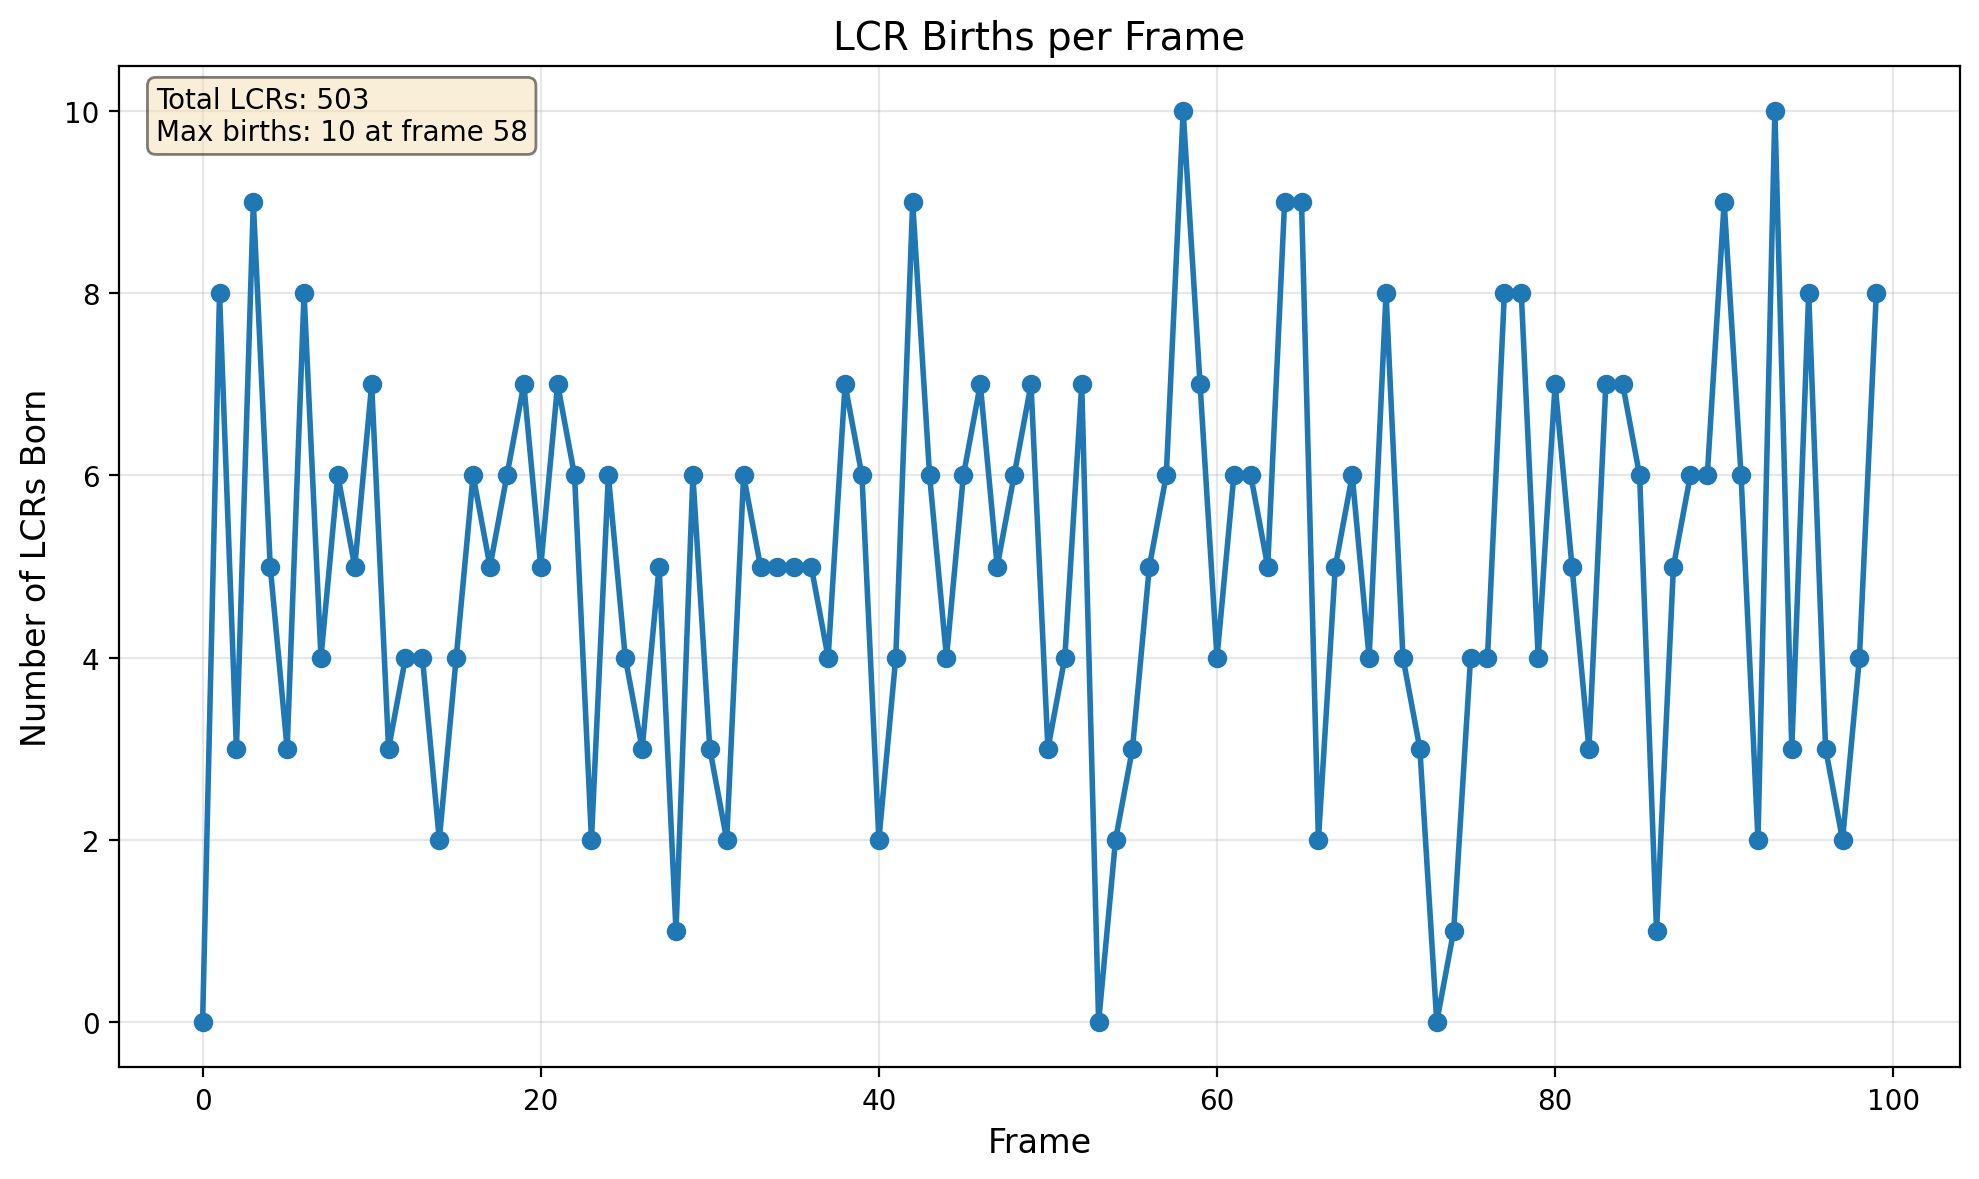

Birth statistics:
  Total LCRs born: 503
  Frames with births: 97
  Average births per frame: 5.03
  Frame with most births: 58 (10 births)


In [138]:
# Create line plot of LCR births per frame
import matplotlib.pyplot as plt
from collections import Counter

# Count births per frame
birth_frames = [lcr.start_time for lcr in all_lcrs]
birth_counts = Counter(birth_frames)

# Create arrays for plotting
frames = list(range(T))
births_per_frame = [birth_counts.get(f, 0) for f in frames]

# Create the plot
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(frames, births_per_frame, marker='o', linewidth=2, markersize=6)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Number of LCRs Born', fontsize=12)
plt.title('LCR Births per Frame', fontsize=14)
plt.grid(True, alpha=0.3)

# Add some statistics
total_births = len(all_lcrs)
max_births = max(births_per_frame)
max_birth_frame = births_per_frame.index(max_births)

plt.text(0.02, 0.98, f'Total LCRs: {total_births}\nMax births: {max_births} at frame {max_birth_frame}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Birth statistics:")
print(f"  Total LCRs born: {total_births}")
print(f"  Frames with births: {len(birth_counts)}")
print(f"  Average births per frame: {total_births/T:.2f}")
print(f"  Frame with most births: {max_birth_frame} ({max_births} births)")

In [139]:
import math

# Stiched filenames are hardcoded
STICHED_MOVIE = False
if filename == 'Cell1_004_50pA_normal1-250_noise1612-1861.tif':
    n_after_skip = T_full / SKIP         
    STITCH_FRAME   = math.ceil(n_after_skip / 2) #stiched exactly in the middle of the time series
    STITCHED_MOVIE = True
else:
    STITCHED_MOVIE = False

In [140]:
if (STICHED_MOVIE):
    F = STICH_FRAME  # Replace with your desired frame number
    
    # Filter all_lcrs
    filtered_lcrs = [lcr for lcr in all_lcrs if lcr.start_time != F]
    
    # Update lcr_by_id lookup
    filtered_lcr_by_id = {lcr.id: lcr for lcr in filtered_lcrs}
    
    # Update tracking results
    tracking_results['all_lcrs'] = filtered_lcrs
    tracking_results['lcr_by_id'] = filtered_lcr_by_id
    
    print(f"Filtered out {len(all_lcrs) - len(filtered_lcrs)} LCRs that started at frame {F}")
    print(f"Remaining LCRs: {len(filtered_lcrs)}")
    
    # IMPORTANT: Update the global all_lcrs variable so the animation code uses filtered LCRs
    all_lcrs = filtered_lcrs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

# — assume all_lcrs, clusters_pixels, stack_raw, T, H, W are already defined —

# ----------------------------------------------------------------------------
# 1) Sanity-check: average LCR duration
# ----------------------------------------------------------------------------
durations = [len(L.frames) for L in all_lcrs]
print(f"Average LCR duration: {np.mean(durations):.2f} frames  (n objects = {len(durations)})")

# ----------------------------------------------------------------------------
# 2) Build an “object ID mask” of shape (T, H, W):
#      background=0, and each LCR gets a unique integer 1…N
# ----------------------------------------------------------------------------
N = len(all_lcrs)
obj_mask = np.zeros((T, H, W), dtype=int)

for i, L in enumerate(all_lcrs):
    obj_id = i + 1  # each LCR → one integer ID in [1…N]
    for t, cid_set in L.frames.items():
        # cid_set may be a single int or a set of ints
        if isinstance(cid_set, set):
            cids = cid_set
        else:
            cids = {cid_set}
        for cid in cids:
            for (y, x) in clusters_pixels[t][cid]:
                obj_mask[t, y, x] = obj_id

# ----------------------------------------------------------------------------
# 3) Build a single ListedColormap of size (N+1):
#    index 0 = (0,0,0,0) → fully transparent,
#    indices 1…N = randomly permuted “non-gray” picks from tab20 (with alpha=1)
# ----------------------------------------------------------------------------

# 3a) Grab the “tab20” base colors (this yields RGB triples in many Matplotlib versions)
base_rgb = np.array(plt.cm.tab20.colors)  # shape typically (20,3)

# 3b) Filter out “gray-ish” entries (low RGB variance)
var_rgb = np.ptp(base_rgb, axis=1)
non_gray_idx = np.where(var_rgb > 0.2)[0]

# 3c) Build a (K,3) pool of non-gray RGBs
pool_rgb = base_rgb[non_gray_idx]  # shape = (K,3)

# 3d) Append alpha=1.0 to each, producing RGBA shape (K,4):
pool_rgba = np.concatenate([
    pool_rgb,
    np.ones((pool_rgb.shape[0], 1), dtype=float)
], axis=1)  # now pool_rgba.shape == (K,4)

# 3e) We want exactly N distinct colors (one for each LCR).  We’ll do:
#     perm = random permutation of [0..N-1], then pool_rgba[perm[i] % K] for i in 0..N-1
np.random.seed(0)  # fix seed if you want reproducibility
perm = np.random.permutation(N)

# 3f) Build a (N+1,4) array “cmap_array”:
#     - row 0 = [0,0,0,0] (fully transparent)
#     - row 1…N = the randomly assigned RGBA from pool_rgba
cmap_array = np.zeros((N + 1, 4), dtype=float)
cmap_array[0] = np.array([0.0, 0.0, 0.0, 0.0])  # background = transparent

for i in range(N):
    cmap_array[i + 1] = pool_rgba[perm[i] % pool_rgba.shape[0]]

# 3g) Create the ListedColormap
cmap = ListedColormap(cmap_array)

# ----------------------------------------------------------------------------
# 4) Animation setup
# ----------------------------------------------------------------------------
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# 4a) Plot the first raw frame in gray
bg = ax.imshow(
    stack_raw[0],
    cmap='gray',
    vmin=stack_raw.min(),
    vmax=stack_raw.max(),
    animated=True
)

# 4b) Plot the first object-ID frame with our custom colormap
#     vmin=0, vmax=N ensures that “0 → transparent” and “k → cmap_array[k]” for k=1..N
ov = ax.imshow(
    obj_mask[0],
    cmap=cmap,
    vmin=0, vmax=N,
    alpha=0.4,
    interpolation='none',
    animated=True
)

# ----------------------------------------------------------------------------
# 5) Update function for FuncAnimation
# ----------------------------------------------------------------------------
def update(frame):
    bg.set_array(stack_raw[frame])
    ov.set_array(obj_mask[frame])
    return bg, ov

# ----------------------------------------------------------------------------
# 6) Build the animation
# ----------------------------------------------------------------------------
anim = FuncAnimation(
    fig,
    update,
    frames=T,
    interval=100,
    blit=True
)

plt.close(fig)           # we only display the animation, not the static figure
HTML(anim.to_jshtml())

In [142]:
# ----------------------------------------------------------------------------
# 4) Animation setup with text label
# ----------------------------------------------------------------------------
fig_w = 10
fig_h = fig_w * (H / W) + 0.5  # Add extra space for text
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=0.9, bottom=0)  # Leave space at top for text

# 4a) Plot the first raw frame in gray
bg = ax.imshow(
    stack_raw[0],
    cmap='gray',
    vmin=stack_raw.min(),
    vmax=stack_raw.max(),
    animated=True
)

# 4b) Plot the first object-ID frame with our custom colormap
ov = ax.imshow(
    obj_mask[0],
    cmap=cmap,
    vmin=0, vmax=N,
    alpha=0.4,
    interpolation='none',
    animated=True
)

# 4c) Add text label at the top
halfway_point = T // 2
text_label = ax.text(0.5, 1.05, 'BEFORE NOISE', 
                     transform=ax.transAxes,
                     fontsize=16, 
                     fontweight='bold',
                     ha='center', 
                     va='bottom',
                     animated=True)

# ----------------------------------------------------------------------------
# 5) Update function for FuncAnimation
# ----------------------------------------------------------------------------
def update(frame):
    bg.set_array(stack_raw[frame])
    ov.set_array(obj_mask[frame])
    
    # Update text based on frame position
    if frame < halfway_point:
        text_label.set_text('BEFORE NOISE')
    else:
        text_label.set_text('WITH NOISE')
    
    return bg, ov, text_label

# ----------------------------------------------------------------------------
# 6) Build the animation
# ----------------------------------------------------------------------------
anim = FuncAnimation(
    fig,
    update,
    frames=T,
    interval=100,
    blit=True
)

# Set a higher animation size limit to avoid the size warning
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # MB (increased from 50)

plt.close(fig)
HTML(anim.to_jshtml())

# ----------------------------------------------------------------------------
# 7) Save the animation with HIGH QUALITY settings (using simple approach)
# ----------------------------------------------------------------------------
import os

# Extract the base filename without path and extension
base_name = os.path.splitext(os.path.basename(data_path))[0]

# Create output filename with LCR tracking suffix
output_filename = f"{base_name}_LCR_tracking.mp4"

# Use the simple high-quality approach that works with any FFmpeg
print(f"Saving high-quality animation...")
anim.save(output_filename, 
          writer='ffmpeg', 
          fps=5,
          bitrate=10000,  # Very high bitrate (10 Mbps)
          dpi=200)        # High DPI for resolution

print(f"Animation saved as '{output_filename}' with high quality")

# If you still have issues, try saving as GIF instead:
# output_gif = f"{base_name}_LCR_tracking.gif"
# anim.save(output_gif, writer='pillow', fps=5, dpi=150)

Saving high-quality animation...
Animation saved as 'Cell1_003_12.5pA_dormant-801-1200_LCR_tracking.mp4' with high quality


## Path Area and Tail Analysis

Mean path area: 35.37375745526839


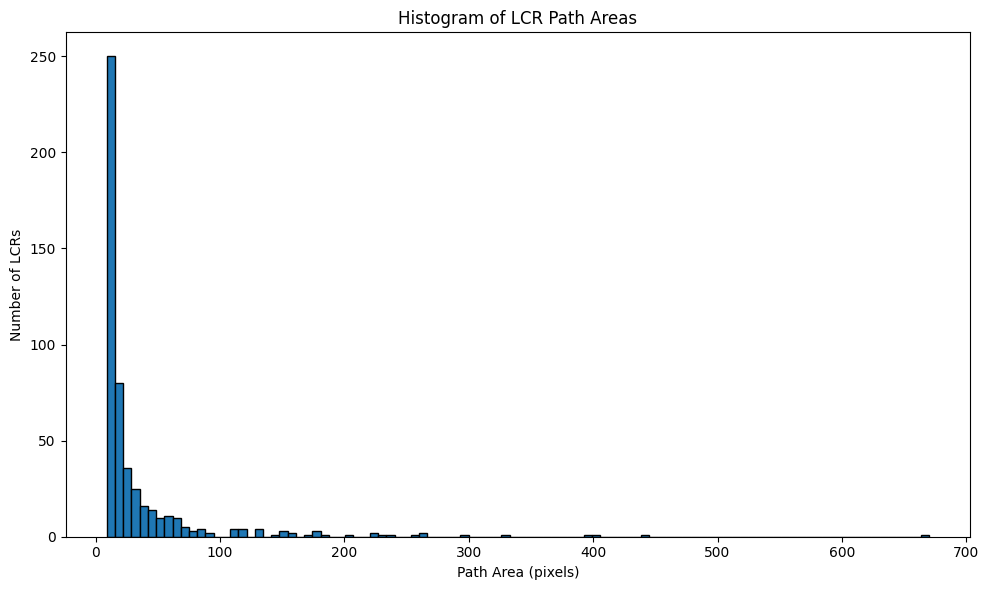

In [143]:
# after your tracking loop, once `all_lcrs` is populated:

# 1) build the list of path‐areas
# 1) build the list of path‐areas and start times
path_areas  = [len(lcr.pixel_coords)   for lcr in all_lcrs]
start_times = [lcr.start_time         for lcr in all_lcrs]

print("Mean path area:", np.mean(path_areas))

# 2) now plot your histogram
import matplotlib.pyplot as plt   # if you haven’t already
plt.figure(figsize=(10,6))
plt.hist(path_areas, bins=100, edgecolor='black')
plt.xlabel('Path Area (pixels)')
plt.ylabel('Number of LCRs')
plt.title('Histogram of LCR Path Areas')
plt.tight_layout()
plt.show()

In [144]:
if filename == 'Cell2_25pA.tif':
    PIXEL_AREA  = 0.1056   # µm² (2×2 binning)
    NOISE_LEVEL = 25     # pA
elif filename == 'Cell1_12.5pA.tif':
    PIXEL_AREA  = 0.1056   # µm² (2×2 binning)
    NOISE_LEVEL = 12.5     # pA
elif filename == 'Cell3_50pA.tif':
    PIXEL_AREA  = 0.0264   # µm² (1×1 binning)
    NOISE_LEVEL = 50     # pA
elif filename == 'Cell3_62.5pA.tif':
    PIXEL_AREA  = 0.0264   # µm² (1×1 binning)
    NOISE_LEVEL = 62.5     # pA
elif filename == 'Cell4_50pA.tif':
    PIXEL_AREA  = 0.1056   # µm² (2×2 binning)
    NOISE_LEVEL = 50     # pA
else:
    print('Using Default settings')
    PIXEL_AREA  = 0.0264   # default (1×1 binning)
    NOISE_LEVEL = None     # unknown

print(f'Pixel Area (in µm²): {PIXEL_AREA}')
print(f'Noise Level (pA): {NOISE_LEVEL}')

Pixel Area (in µm²): 0.1056
Noise Level (pA): 12.5


=== Diagnostic Information ===
Total LCRs: 503
Path areas range: 0.95 to 70.75 µm²
Mean path area: 3.74 µm²
Median path area: 1.69 µm²

LCRs before midpoint (frame 50): 251
LCRs after midpoint: 252

=== Excess Mass Cutpoint ===
Natural cutpoint: 0.95 µm²
Percentile: 0.0%

=== L-KURTOSIS (τ4) - Tail Weight Measure ===
Early: τ4 = 0.4340
Late:  τ4 = 0.4612
Change: 0.0272 (6.3%)
→ Late has heavier tails

=== TAIL STATISTICS (above 0.95 µm²) ===

1. Mean Excess:
   Early: 2.7
   Late:  2.8
   Change: 3.9%
1. L-kurtosis (τ4): Early=0.4340, Late=0.4612
2. Log Mean Excess: Early=0.818, Late=0.842
3. Mean Excess: Early=2.7, Late=2.8

All are sensitive to large values in the tail.


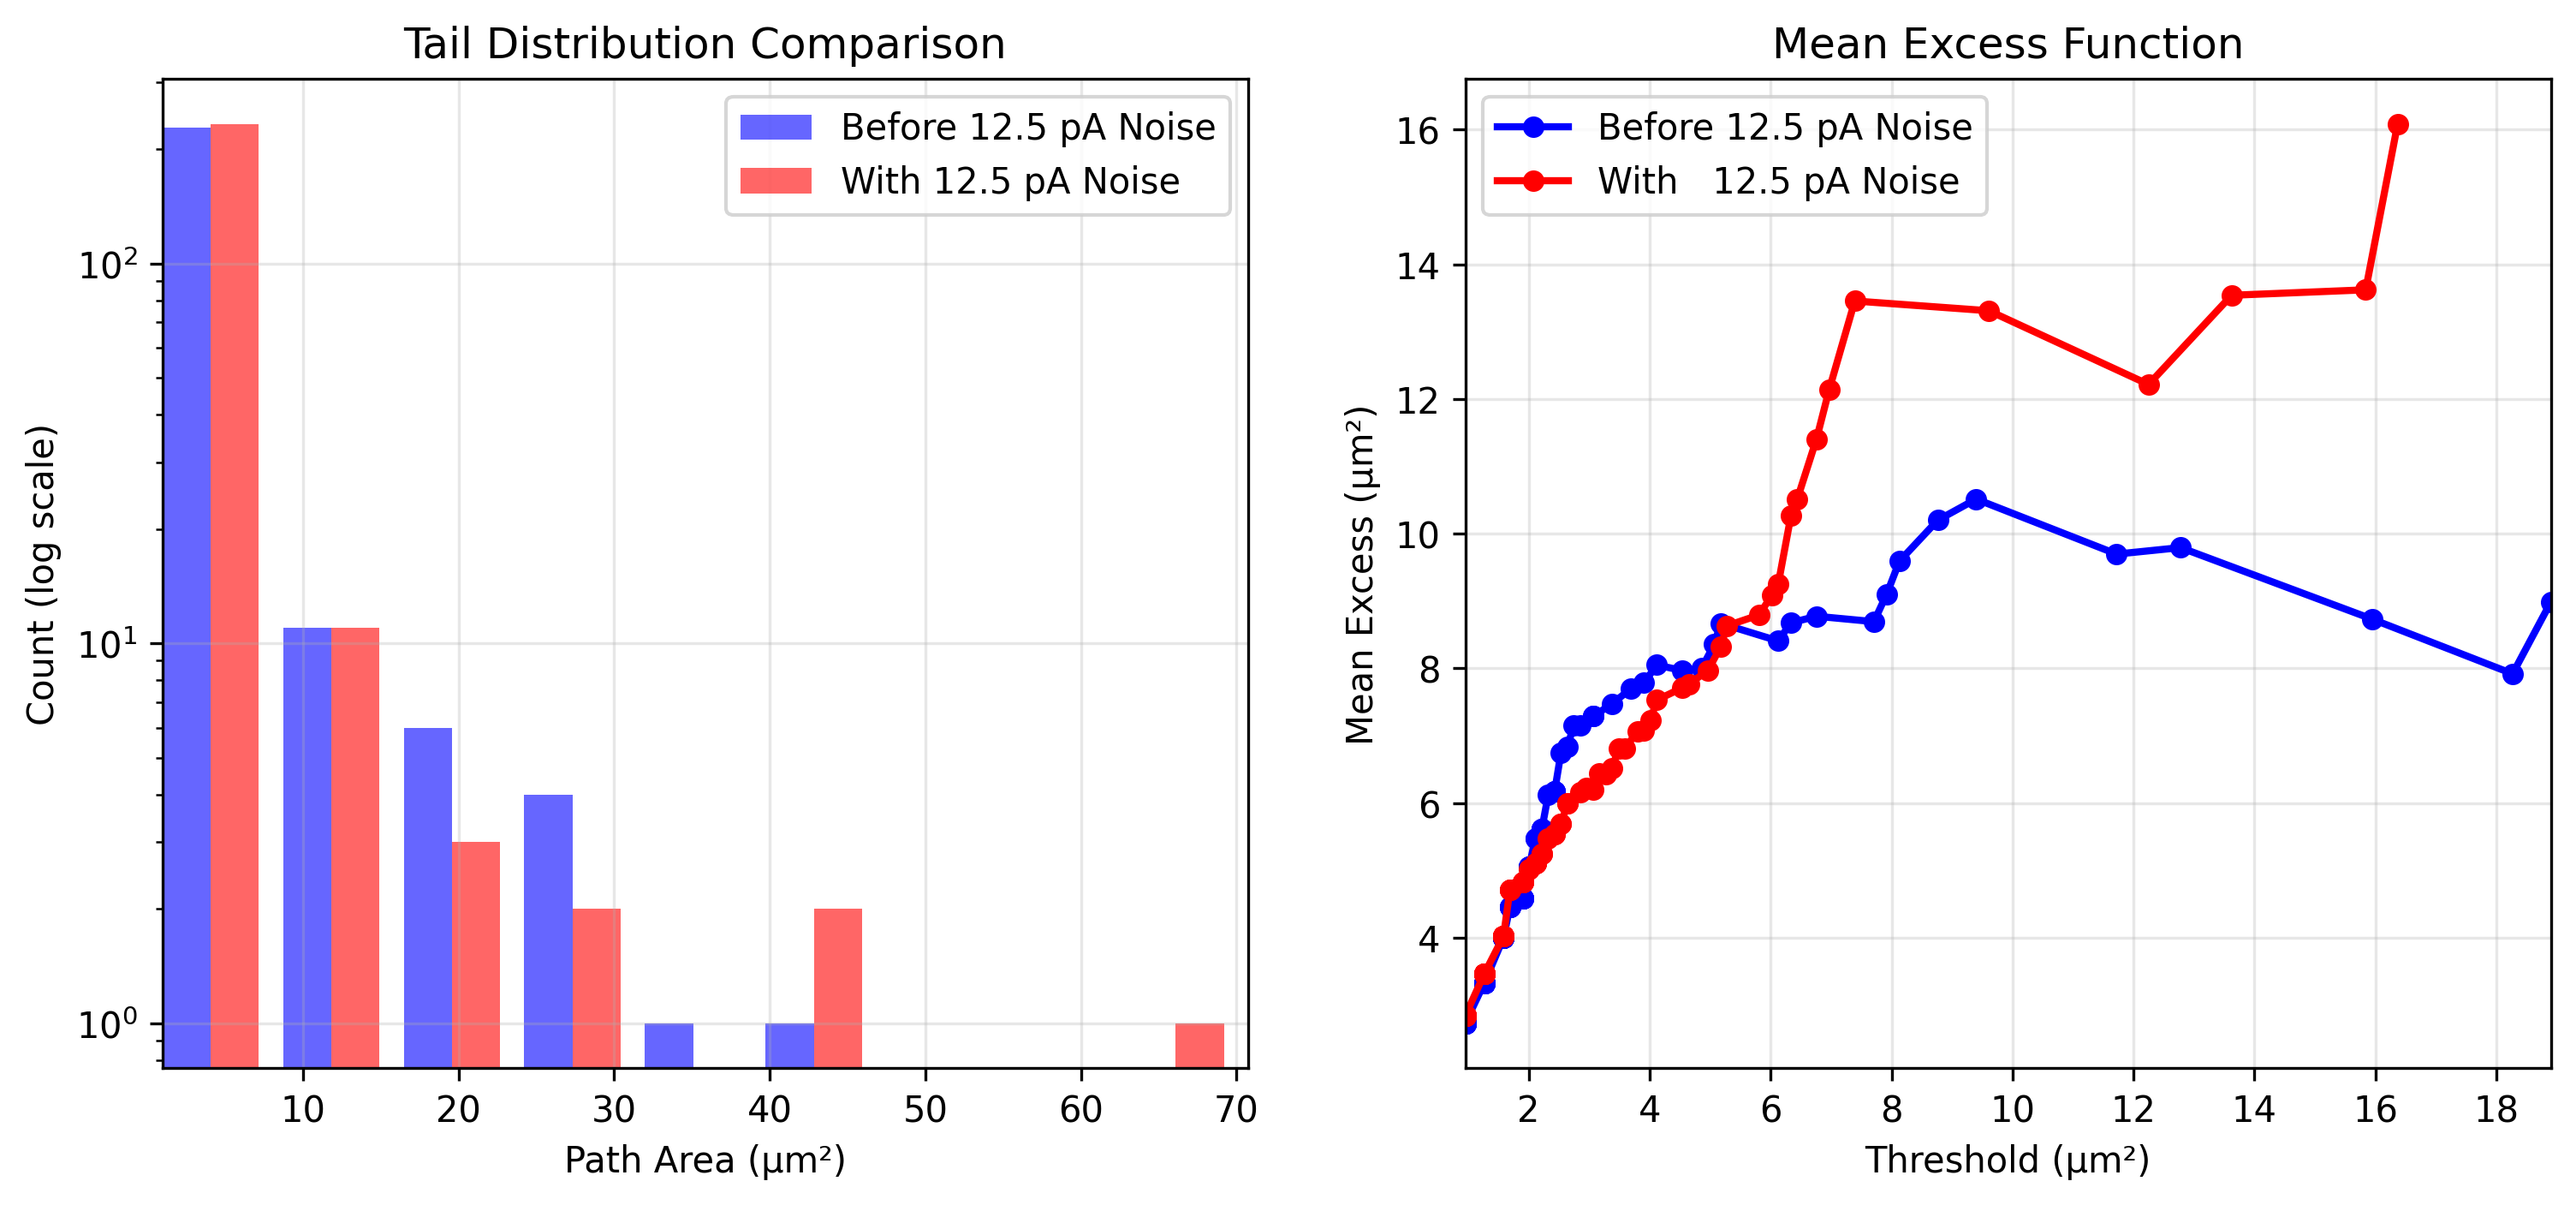

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Convert pixel counts to µm² ---
path_areas_um2 = np.array(path_areas) * PIXEL_AREA

# --- Diagnostic Information ---
print("=== Diagnostic Information ===")
print(f"Total LCRs: {len(path_areas_um2)}")
print(f"Path areas range: {path_areas_um2.min():.2f} to {path_areas_um2.max():.2f} µm²")
print(f"Mean path area: {path_areas_um2.mean():.2f} µm²")
print(f"Median path area: {np.median(path_areas_um2):.2f} µm²")

# --- Split before/after midpoint ---
mid = T // 2
early = np.array([pa * PIXEL_AREA for pa, st in zip(path_areas, start_times) if st <= mid])
late  = np.array([pa * PIXEL_AREA for pa, st in zip(path_areas, start_times) if st >  mid])

print(f"\nLCRs before midpoint (frame {mid}): {len(early)}")
print(f"LCRs after midpoint: {len(late)}")

# --- L-moment calculation ---
def calculate_l_moments(data):
    """Calculate L-moments including L-kurtosis (τ4)."""
    sd = np.sort(data)
    n = len(sd)
    if n < 4:
        return {'tau_4': np.nan, 'l1': np.nan, 'l2': np.nan}
    b0 = np.mean(sd)
    b1 = np.sum(sd * np.arange(n)   / (n - 1))              / n
    b2 = np.sum(sd * np.arange(n) * (np.arange(n)-1)   \
                / ((n - 1)*(n - 2)))                      / n
    b3 = np.sum(sd * np.arange(n) * (np.arange(n)-1) * (np.arange(n)-2) \
                / ((n - 1)*(n - 2)*(n - 3)))             / n
    l1 = b0
    l2 = 2*b1 - b0
    l3 = 6*b2 - 6*b1 + b0
    l4 = 20*b3 - 30*b2 + 12*b1 - b0
    tau_4 = l4 / l2 if l2 != 0 else np.nan
    return {'tau_4': tau_4, 'l1': l1, 'l2': l2}

# --- Excess‐mass cutpoint ---
def find_excess_mass_cutpoint(data):
    sd = np.sort(data)
    cs = np.cumsum(sd)
    tot = cs[-1]
    exp = np.linspace(0, tot, len(sd))
    ex = cs - exp
    return sd[np.argmax(ex)]

# --- Tail‐stats ---
def calculate_tail_statistics(data, cutpoint):
    tail = data[data > cutpoint]
    if len(tail) < 2:
        return {k: np.nan for k in (
            'mean_excess','log_mean_excess','tail_moment',
            'conditional_tail_exp','pot_mean'
        )} | {'tail_fraction': 0, 'tail_mass_fraction': 0}
    mean_excess = np.mean(tail - cutpoint)
    log_mean_excess = np.mean(np.log(tail / cutpoint))
    tail_moment = np.mean((tail - cutpoint)**2)
    cond_tail = np.mean(tail) / cutpoint
    pot_mean = np.sum(tail - cutpoint) / len(data)
    frac = len(tail) / len(data)
    mass_frac = np.sum(tail) / np.sum(data)
    return {
        'mean_excess': mean_excess,
        'log_mean_excess': log_mean_excess,
        'tail_moment': tail_moment,
        'conditional_tail_exp': cond_tail,
        'pot_mean': pot_mean,
        'tail_fraction': frac,
        'tail_mass_fraction': mass_frac
    }

# --- Compute cutpoint on µm² ---
all_data = np.concatenate([early, late])
cutpoint = round(find_excess_mass_cutpoint(all_data), 2)

print(f"\n=== Excess Mass Cutpoint ===")
print(f"Natural cutpoint: {cutpoint:.2f} µm²")
print(f"Percentile: {100 * np.sum(all_data <= cutpoint) / len(all_data):.1f}%")

# --- L-moments & tail statistics ---
lm_early = calculate_l_moments(early)
lm_late  = calculate_l_moments(late)
tail_stats_early = calculate_tail_statistics(early, cutpoint)
tail_stats_late  = calculate_tail_statistics(late,  cutpoint)

# --- Print L-kurtosis & tail stats ---
print("\n=== L-KURTOSIS (τ4) - Tail Weight Measure ===")
print(f"Early: τ4 = {lm_early['tau_4']:.4f}")
print(f"Late:  τ4 = {lm_late['tau_4']:.4f}")
print(f"Change: {lm_late['tau_4'] - lm_early['tau_4']:.4f} "
      f"({100*(lm_late['tau_4']/lm_early['tau_4'] - 1):.1f}%)")
print(f"→ {'Late' if lm_late['tau_4'] > lm_early['tau_4'] else 'Early'} has heavier tails")

print(f"\n=== TAIL STATISTICS (above {cutpoint:.2f} µm²) ===")
print(f"\n1. Mean Excess:")
print(f"   Early: {tail_stats_early['mean_excess']:.1f}")
print(f"   Late:  {tail_stats_late['mean_excess']:.1f}")
print(f"   Change: {100*(tail_stats_late['mean_excess']/tail_stats_early['mean_excess'] - 1):.1f}%")

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Shared data range
data_min, data_max = all_data.min(), all_data.max()

# 1) Tail distribution (log scale)
bins = np.linspace(data_min, data_max, 10)
early_above = early[early > cutpoint]
late_above  = late[ late > cutpoint]
counts_e, _ = np.histogram(early_above, bins=bins)
counts_l, _ = np.histogram(late_above,  bins=bins)
width = bins[1] - bins[0]
mask_e = counts_e > 0
mask_l = counts_l > 0

ax1.bar(bins[:-1][mask_e], counts_e[mask_e], width*0.4,
        alpha=0.6, color='blue',
        label=f"Before {NOISE_LEVEL} pA Noise", align='edge')
ax1.bar(bins[:-1][mask_l] + width*0.4, counts_l[mask_l], width*0.4,
        alpha=0.6, color='red',
        label=f"With {NOISE_LEVEL} pA Noise", align='edge')
ax1.set_yscale('log')
ax1.set_xlabel('Path Area (µm²)')
ax1.set_ylabel('Count (log scale)')
ax1.set_title('Tail Distribution Comparison')
ax1.set_xlim(data_min, data_max)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Mean Excess Function with each curve ending at its own maximum

# choose 101 quantile positions between 1% and 100%
qs = np.linspace(0.01, 0.97, 101)

# sort early and late data separately
sd_e = np.sort(early)
sd_l = np.sort(late)
n_e  = len(sd_e)
n_l  = len(sd_l)

# map quantiles to nearest real observations for each group
ranks_e      = np.rint((n_e - 1) * qs).astype(int)
ranks_l      = np.rint((n_l - 1) * qs).astype(int)
thresholds_e = sd_e[ranks_e]
thresholds_l = sd_l[ranks_l]

# compute mean‐excess at each threshold, ≥ so max gives 0
me_e = [
    np.mean(early[early >= t] - t) if np.any(early >= t) else 0.0
    for t in thresholds_e
]
me_l = [
    np.mean(late[ late >= t] - t) if np.any(late  >= t) else 0.0
    for t in thresholds_l
]

# plot
ax2.plot(thresholds_e, me_e, 'b-o', linewidth=2, markersize=5,
         label=f"Before {NOISE_LEVEL} pA Noise")
ax2.plot(thresholds_l, me_l, 'r-o', linewidth=2, markersize=5,
         label=f"With   {NOISE_LEVEL} pA Noise")

# adjust axes
all_thresh = np.concatenate([thresholds_e, thresholds_l])
ax2.set_xlim(all_thresh.min(), all_thresh.max())
ax2.set_xlabel('Threshold (µm²)')
ax2.set_ylabel('Mean Excess (µm²)')
ax2.set_title('Mean Excess Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Recommendations for paired tests ---
print(f"1. L-kurtosis (τ4): Early={lm_early['tau_4']:.4f}, Late={lm_late['tau_4']:.4f}")
print(f"2. Log Mean Excess: Early={tail_stats_early['log_mean_excess']:.3f}, "
      f"Late={tail_stats_late['log_mean_excess']:.3f}")
print(f"3. Mean Excess: Early={tail_stats_early['mean_excess']:.1f}, "
      f"Late={tail_stats_late['mean_excess']:.1f}")
print("\nAll are sensitive to large values in the tail.")